In [1]:
import os
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime
import pytz
from numba import njit

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import base_optimizer

import vectorbt as vbt
from vectorbt.generic.nb import nanmean_nb
from vectorbt.portfolio.nb import order_nb, sort_call_seq_nb
from vectorbt.portfolio.enums import SizeType, Direction

In [2]:
start_date = datetime(2005, 1, 1, tzinfo=pytz.utc)
end_date = datetime(2024, 4, 1, tzinfo=pytz.utc)

vbt.settings.array_wrapper['freq'] = 'days'
vbt.settings.returns['year_freq'] = '252 days'
vbt.settings.portfolio['seed'] = 42
vbt.settings.portfolio.stats['incl_unrealized'] = True

In [3]:

# Symbols 
symbols = ['TLT','GLD','XLP','XLK','XLV']  

# Download historical data
price = yf.download(symbols, start="2005-01-01", end="2024-03-31")['Adj Close']
price.ffill(inplace=True)  # Forward-fill to handle missing values
price.head(5)

[*********************100%%**********************]  5 of 5 completed


Ticker,GLD,TLT,XLK,XLP,XLV
Date,,,,,
2005-01-03,43.020000,48.357414,16.243130,14.010856,21.538515
2005-01-04,42.740002,47.850616,15.940459,13.962292,21.365274
2005-01-05,42.669998,48.106747,15.886144,13.889449,21.329189
2005-01-06,42.150002,48.139423,15.839581,13.956226,21.487989
2005-01-07,41.840000,48.248383,15.870617,14.022992,21.473549


In [4]:
#yfdata = vbt.YFData.download(symbols, start=start_date, end=end_date)
#print(yfdata.symbols)


In [5]:
#ohlcv = yfdata.concat()
#print(ohlcv.keys())

In [6]:
#price = ohlcv['Close']
#print(price.head(5))

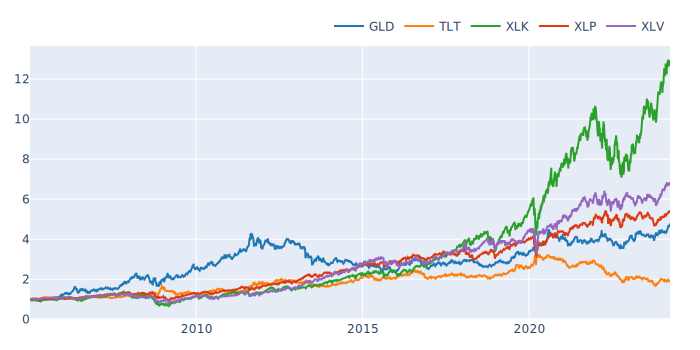

In [7]:
# Plot normalized price series
(price / price.iloc[0]).vbt.plot().show_svg()

In [8]:
returns = price.pct_change()

In [9]:
print(returns.mean())

Ticker
GLD    0.000385
TLT    0.000181
XLK    0.000624
XLP    0.000391
XLV    0.000454
dtype: float64


In [10]:
print(returns.std())

Ticker
GLD    0.011085
TLT    0.009335
XLK    0.013903
XLP    0.008971
XLV    0.010587
dtype: float64


In [11]:
print(returns.corr())

Ticker       GLD       TLT       XLK       XLP       XLV
Ticker                                                  
GLD     1.000000  0.166242  0.034841  0.023547  0.019862
TLT     0.166242  1.000000 -0.276959 -0.237760 -0.268002
XLK     0.034841 -0.276959  1.000000  0.678040  0.721355
XLP     0.023547 -0.237760  0.678040  1.000000  0.734611
XLV     0.019862 -0.268002  0.721355  0.734611  1.000000


## vectorbt: one-time allocation

### One-time allocation

In [12]:
np.random.seed(42)

# Generate random weights, n times
weights = []
w = np.array([.2, .2, .2, .2, .2])
weights.append(w)
w = np.array([.16, .17, .17, .25, .25])
weights.append(w)


print(len(weights))
print(weights)

num_tests = len(weights)


2
[array([0.2, 0.2, 0.2, 0.2, 0.2]), array([0.16, 0.17, 0.17, 0.25, 0.25])]


In [13]:
# Build column hierarchy such that one weight corresponds to one price series
_price = price.vbt.tile(num_tests, keys=pd.Index(np.arange(num_tests), name='symbol_group'))
_price = _price.vbt.stack_index(pd.Index(np.concatenate(weights), name='weights'))

print(_price.columns)
print(_price)

MultiIndex([( 0.2, 0, 'GLD'),
            ( 0.2, 0, 'TLT'),
            ( 0.2, 0, 'XLK'),
            ( 0.2, 0, 'XLP'),
            ( 0.2, 0, 'XLV'),
            (0.16, 1, 'GLD'),
            (0.17, 1, 'TLT'),
            (0.17, 1, 'XLK'),
            (0.25, 1, 'XLP'),
            (0.25, 1, 'XLV')],
           names=['weights', 'symbol_group', 'Ticker'])
weights             0.20                                                \
symbol_group           0                                                 
Ticker               GLD        TLT         XLK        XLP         XLV   
Date                                                                     
2005-01-03     43.020000  48.357414   16.243130  14.010856   21.538515   
2005-01-04     42.740002  47.850616   15.940459  13.962292   21.365274   
2005-01-05     42.669998  48.106747   15.886144  13.889449   21.329189   
2005-01-06     42.150002  48.139423   15.839581  13.956226   21.487989   
2005-01-07     41.840000  48.248383   15.870617  14

In [14]:
# Define order size
size = np.full_like(_price, np.nan)
size[0, :] = np.concatenate(weights)  # allocate at first timestamp, do nothing afterwards

print(size.shape)

(4842, 10)


In [15]:
print(size)

[[0.2  0.2  0.2  ... 0.17 0.25 0.25]
 [ nan  nan  nan ...  nan  nan  nan]
 [ nan  nan  nan ...  nan  nan  nan]
 ...
 [ nan  nan  nan ...  nan  nan  nan]
 [ nan  nan  nan ...  nan  nan  nan]
 [ nan  nan  nan ...  nan  nan  nan]]


In [16]:
# Run simulation
pf = vbt.Portfolio.from_orders(
    close=_price,
    size=size,
    size_type='targetpercent',
    group_by='symbol_group',
    cash_sharing=True
) # all weights sum to 1, no shorting, and 100% investment in risky assets

print(len(pf.orders))

10


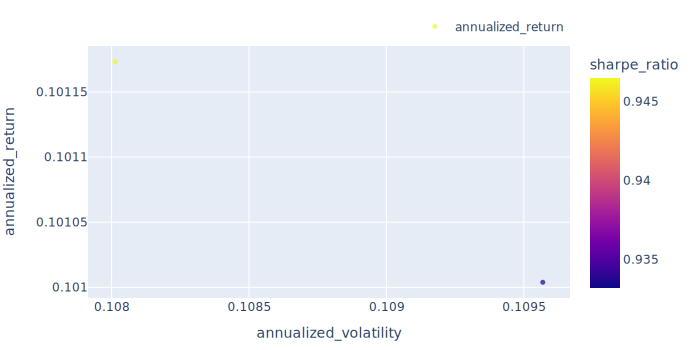

In [17]:
# Plot annualized return against volatility, color by sharpe ratio
annualized_return = pf.annualized_return()
annualized_return.index = pf.annualized_volatility()
annualized_return.vbt.scatterplot(
    trace_kwargs=dict(
        mode='markers', 
        marker=dict(
            color=pf.sharpe_ratio(),
            colorbar=dict(
                title='sharpe_ratio'
            ),
            size=5,
            opacity=0.7
        )
    ),
    xaxis_title='annualized_volatility',
    yaxis_title='annualized_return'
).show_svg()

In [18]:
# Get index of the best group according to the target metric
best_symbol_group = pf.sharpe_ratio().idxmax()

print(best_symbol_group)

0


In [19]:
# Print best weights
print(weights[best_symbol_group])

[0.2 0.2 0.2 0.2 0.2]


In [20]:
# Compute default stats
print(pf.iloc[best_symbol_group].stats())

Start                         2005-01-03 00:00:00
End                           2024-03-28 00:00:00
Period                         4842 days 00:00:00
Start Value                                 100.0
End Value                              637.127071
Total Return [%]                       537.127071
Benchmark Return [%]                   537.127071
Max Gross Exposure [%]                      100.0
Total Fees Paid                               0.0
Max Drawdown [%]                        20.989299
Max Drawdown Duration           492 days 00:00:00
Total Trades                                    5
Total Closed Trades                             0
Total Open Trades                               5
Open Trade PnL                         537.127071
Win Rate [%]                                  NaN
Best Trade [%]                                NaN
Worst Trade [%]                               NaN
Avg Winning Trade [%]                         NaN
Avg Losing Trade [%]                          NaN


### Rebalance monthly

In [21]:
# Select the first index of each month
rb_mask = ~_price.index.to_period('Y').duplicated()

print(rb_mask.sum())
print(rb_mask)

20
[ True False False ... False False False]


In [22]:
_price.index.to_period('Y')


PeriodIndex(['2005', '2005', '2005', '2005', '2005', '2005', '2005', '2005',
             '2005', '2005',
             ...
             '2024', '2024', '2024', '2024', '2024', '2024', '2024', '2024',
             '2024', '2024'],
            dtype='period[Y-DEC]', name='Date', length=4842)

In [23]:
size = np.full_like(_price, np.nan, dtype=np.float64)

# Set rows where rb_mask is True to [0.2, 0.2, 0.2]
size[rb_mask] = np.concatenate(weights)
print(size[240:260])

[[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [0.2  0.2  0.2  0.2  0.2  0.16 0.17 0.17 0.25 0.25]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan

In [24]:
# Run simulation
pf = vbt.Portfolio.from_orders(
    close=_price,
    size=size,
    size_type='targetpercent',
    group_by='symbol_group',
    cash_sharing=True,
    call_seq = 'auto'
) # all weights sum to 1, no shorting, and 100% investment in risky assets

print(len(pf.orders))

200


In [25]:
pf.orders.records_readable.head(50)


,Order Id,Column,Timestamp,Size,Price,Fees,Side
0,0,"(0.2, 0, GLD)",2005-01-03,0.464900,43.020000,0.0,Buy
1,1,"(0.2, 0, TLT)",2005-01-03,0.413587,48.357414,0.0,Buy
2,2,"(0.2, 0, XLK)",2005-01-03,1.231290,16.243130,0.0,Buy
3,3,"(0.2, 0, XLP)",2005-01-03,1.427465,14.010856,0.0,Buy
4,4,"(0.2, 0, XLV)",2005-01-03,0.928569,21.538515,0.0,Buy
5,5,"(0.2, 0, GLD)",2006-01-03,0.053223,53.119999,0.0,Sell
6,6,"(0.2, 0, XLV)",2006-01-03,0.003012,23.474384,0.0,Buy
7,7,"(0.2, 0, TLT)",2006-01-03,0.004267,52.334721,0.0,Buy
8,8,"(0.2, 0, XLP)",2006-01-03,0.080506,14.501810,0.0,Buy
9,9,"(0.2, 0, XLK)",2006-01-03,0.082016,16.651335,0.0,Buy


In [26]:
pf.get_trades().records_readable 


,Exit Trade Id,Column,Size,Entry Timestamp,Avg Entry Price,Entry Fees,Exit Timestamp,Avg Exit Price,Exit Fees,PnL,Return,Direction,Status,Position Id
0,0,"(0.2, 0, GLD)",0.053223,2005-01-03,43.020000,0.0,2006-01-03,53.119999,0.0,0.537550,0.234774,Long,Closed,0
1,1,"(0.2, 0, GLD)",0.025848,2005-01-03,43.020000,0.0,2007-01-03,62.279999,0.0,0.497827,0.447699,Long,Closed,0
2,2,"(0.2, 0, GLD)",0.059336,2005-01-03,43.020000,0.0,2008-01-02,84.860001,0.0,2.482639,0.972571,Long,Closed,0
3,3,"(0.2, 0, GLD)",0.031660,2005-01-03,43.020000,0.0,2009-01-02,86.230003,0.0,1.368039,1.004417,Long,Closed,0
4,4,"(0.2, 0, GLD)",0.022461,2005-01-03,43.020000,0.0,2010-01-04,109.800003,0.0,1.499928,1.552301,Long,Closed,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,92,"(0.25, 1, XLV)",0.038008,2005-01-03,24.390068,0.0,2018-01-02,75.215111,0.0,1.931742,2.083842,Long,Closed,9
93,93,"(0.25, 1, XLV)",0.062366,2005-01-03,24.390068,0.0,2019-01-02,77.852402,0.0,3.334252,2.191971,Long,Closed,9
94,94,"(0.25, 1, XLV)",0.097673,2005-01-03,31.336502,0.0,2022-01-03,134.565674,0.0,10.082661,3.294215,Long,Closed,9
95,95,"(0.25, 1, XLV)",0.097004,2005-01-03,31.336502,0.0,2023-01-03,132.755692,0.0,9.838113,3.236455,Long,Closed,9


In [27]:
mask = ~_price.index.to_period('M').duplicated()

cum_positions = pf.asset_flow().cumsum()
cum_positions[mask]

# Display the result
# print("End-of-Month Positions:")
# print(eom_positions)

weights           0.20                                              0.16  \
symbol_group         0                                                 1   
Ticker             GLD       TLT       XLK       XLP       XLV       GLD   
Date                                                                       
2005-01-03    0.464900  0.413587  1.231290  1.427465  0.928569  0.371920   
2005-02-01    0.464900  0.413587  1.231290  1.427465  0.928569  0.371920   
2005-03-01    0.464900  0.413587  1.231290  1.427465  0.928569  0.371920   
2005-04-01    0.464900  0.413587  1.231290  1.427465  0.928569  0.371920   
2005-05-02    0.464900  0.413587  1.231290  1.427465  0.928569  0.371920   
...                ...       ...       ...       ...       ...       ...   
2023-11-01    0.607442  1.073750  0.851722  1.446744  0.782708  0.496048   
2023-12-01    0.607442  1.073750  0.851722  1.446744  0.782708  0.496048   
2024-01-02    0.621078  1.220832  0.632990  1.638168  0.856606  0.499054   
2024-02-01    0.621078  1.220832  0.632990  1.638168  0.856606  0.499054   
2024-03-01    0.621078  1.220832  0.632990  1.638168  0.856606  0.499054   

weights           0.17                0.25            
symbol_group         1                   1            
Ticker             TLT       XLK       XLP       XLV  
Date                                                  
2005-01-03    0.351549  1.046596  1.784331  1.160711  
2005-02-01    0.351549  1.046596  1.784331  1.160711  
2005-03-01    0.351549  1.046596  1.784331  1.160711  
2005-04-01    0.351549  1.046596  1.784331  1.160711  
2005-05-02    0.351549  1.046596  1.784331  1.160711  
...                ...       ...       ...       ...  
2023-11-01    0.931646  0.739002  1.845995  0.998709  
2023-12-01    0.931646  0.739002  1.845995  0.998709  
2024-01-02    1.042282  0.540414  2.056739  1.075479  
2024-02-01    1.042282  0.540414  2.056739  1.075479  
2024-03-01    1.042282  0.540414  2.056739  1.075479  

[231 rows x 10 columns]

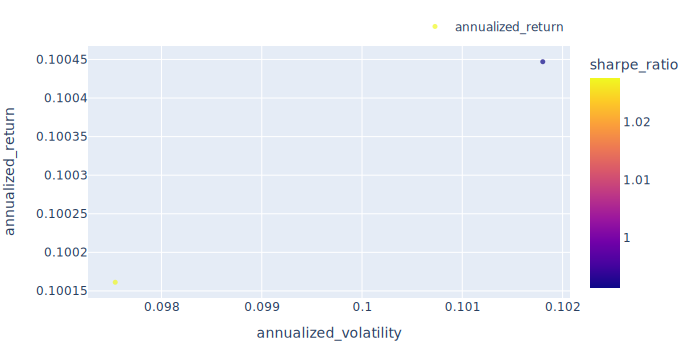

In [28]:
# Plot annualized return against volatility, color by sharpe ratio
annualized_return = pf.annualized_return()
annualized_return.index = pf.annualized_volatility()
annualized_return.vbt.scatterplot(
    trace_kwargs=dict(
        mode='markers', 
        marker=dict(
            color=pf.sharpe_ratio(),
            colorbar=dict(
                title='sharpe_ratio'
            ),
            size=5,
            opacity=0.7
        )
    ),
    xaxis_title='annualized_volatility',
    yaxis_title='annualized_return'
).show_svg()

In [29]:
print(pf.iloc[0].stats())

Start                                  2005-01-03 00:00:00
End                                    2024-03-28 00:00:00
Period                                  4842 days 00:00:00
Start Value                                          100.0
End Value                                       625.970178
Total Return [%]                                525.970178
Benchmark Return [%]                            537.127071
Max Gross Exposure [%]                               100.0
Total Fees Paid                                        0.0
Max Drawdown [%]                                 20.756628
Max Drawdown Duration                    501 days 00:00:00
Total Trades                                            48
Total Closed Trades                                     43
Total Open Trades                                        5
Open Trade PnL                                  346.415569
Win Rate [%]                                         100.0
Best Trade [%]                                  956.9504

In [30]:
rb_size = np.full_like(_price, np.nan)
rb_size[rb_mask, :] = np.concatenate(weights)  # allocate at mask

print(rb_size.shape)

(4842, 10)


In [31]:
# Run simulation, with rebalancing monthly
rb_pf = vbt.Portfolio.from_orders(
    close=_price,
    size=rb_size,
    size_type='targetpercent',
    group_by='symbol_group',
    cash_sharing=True,
    call_seq='auto'  # important: sell before buy
)

print(len(rb_pf.orders))

200


In [32]:
rb_best_symbol_group = rb_pf.sharpe_ratio().idxmax()

print(rb_best_symbol_group)

0


In [33]:
print(weights[rb_best_symbol_group])

[0.2 0.2 0.2 0.2 0.2]


In [34]:
print(rb_pf.iloc[rb_best_symbol_group].stats())

Start                                  2005-01-03 00:00:00
End                                    2024-03-28 00:00:00
Period                                  4842 days 00:00:00
Start Value                                          100.0
End Value                                       625.970178
Total Return [%]                                525.970178
Benchmark Return [%]                            537.127071
Max Gross Exposure [%]                               100.0
Total Fees Paid                                        0.0
Max Drawdown [%]                                 20.756628
Max Drawdown Duration                    501 days 00:00:00
Total Trades                                            48
Total Closed Trades                                     43
Total Open Trades                                        5
Open Trade PnL                                  346.415569
Win Rate [%]                                         100.0
Best Trade [%]                                  956.9504

In [35]:
def plot_allocation(rb_pf):
    # Plot weights development of the portfolio
    rb_asset_value = rb_pf.asset_value(group_by=False)
    rb_value = rb_pf.value()
    rb_idxs = np.flatnonzero((rb_pf.asset_flow() != 0).any(axis=1))
    rb_dates = rb_pf.wrapper.index[rb_idxs]
    fig = (rb_asset_value.vbt / rb_value).vbt.plot(
        trace_names=symbols,
        trace_kwargs=dict(
            stackgroup='one'
        )
    )
    for rb_date in rb_dates:
        fig.add_shape(
            dict(
                xref='x',
                yref='paper',
                x0=rb_date,
                x1=rb_date,
                y0=0,
                y1=1,
                line_color=fig.layout.template.layout.plot_bgcolor
            )
        )
    fig.show_svg()

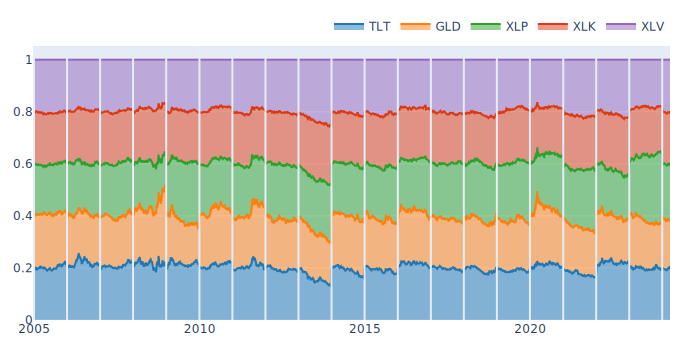

In [36]:
plot_allocation(rb_pf.iloc[rb_best_symbol_group])  # best group

### Search and rebalance every 30 days

Utilize low-level API to dynamically search for best Sharpe ratio and rebalance accordingly. Compared to previous method, we won't utilize stacking, but do search in a loop instead. We also will use days instead of months, as latter may contain a various number of trading days.

In [37]:
srb_sharpe = np.full(price.shape[0], np.nan)

@njit
def pre_sim_func_nb(c, every_nth):
    # Define rebalancing days
    c.segment_mask[:, :] = False
    c.segment_mask[every_nth::every_nth, :] = True
    return ()

@njit
def find_weights_nb(c, price, num_tests):
    # Find optimal weights based on best Sharpe ratio
    returns = (price[1:] - price[:-1]) / price[:-1]
    returns = returns[1:, :]  # cannot compute np.cov with NaN
    mean = nanmean_nb(returns)
    cov = np.cov(returns, rowvar=False)  # masked arrays not supported by Numba (yet)
    best_sharpe_ratio = -np.inf
    weights = np.full(c.group_len, np.nan, dtype=np.float_)
    
    for i in range(num_tests):
        # Generate weights
        w = np.random.random_sample(c.group_len)
        w = w / np.sum(w)
        
        # Compute annualized mean, covariance, and Sharpe ratio
        p_return = np.sum(mean * w) * ann_factor
        p_std = np.sqrt(np.dot(w.T, np.dot(cov, w))) * np.sqrt(ann_factor)
        sharpe_ratio = p_return / p_std
        if sharpe_ratio > best_sharpe_ratio:
            best_sharpe_ratio = sharpe_ratio
            weights = w
            
    return best_sharpe_ratio, weights

@njit
def pre_segment_func_nb(c, find_weights_nb, history_len, ann_factor, num_tests, srb_sharpe):
    if history_len == -1:
        # Look back at the entire time period
        close = c.close[:c.i, c.from_col:c.to_col]
    else:
        # Look back at a fixed time period
        if c.i - history_len <= 0:
            return (np.full(c.group_len, np.nan),)  # insufficient data
        close = c.close[c.i - history_len:c.i, c.from_col:c.to_col]

    # Find optimal weights
    best_sharpe_ratio, weights = find_weights_nb(c, close, num_tests)
    srb_sharpe[c.i] = best_sharpe_ratio

    # Update valuation price and reorder orders
    size_type = SizeType.TargetPercent
    direction = Direction.LongOnly
    order_value_out = np.empty(c.group_len, dtype=np.float_)
    for k in range(c.group_len):
        col = c.from_col + k
        c.last_val_price[col] = c.close[c.i, col]
    sort_call_seq_nb(c, weights, size_type, direction, order_value_out)

    return (weights,)

@njit
def order_func_nb(c, weights):
    col_i = c.call_seq_now[c.call_idx]
    return order_nb(
        weights[col_i], 
        c.close[c.i, c.col],
        size_type=SizeType.TargetPercent
    )

In [38]:
ann_factor = returns.vbt.returns.ann_factor

In [39]:
# Run simulation using a custom order function
srb_pf = vbt.Portfolio.from_order_func(
    price,
    order_func_nb,
    pre_sim_func_nb=pre_sim_func_nb,
    pre_sim_args=(30,),
    pre_segment_func_nb=pre_segment_func_nb,
    pre_segment_args=(find_weights_nb, -1, ann_factor, num_tests, srb_sharpe),
    cash_sharing=True, 
    group_by=True
)

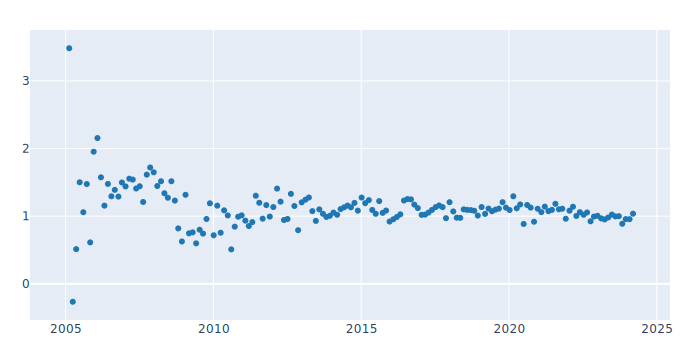

In [40]:
# Plot best Sharpe ratio at each rebalancing day
pd.Series(srb_sharpe, index=price.index).vbt.scatterplot(trace_kwargs=dict(mode='markers')).show_svg()

In [41]:
print(srb_pf.stats())

Start                                  2005-01-03 00:00:00
End                                    2024-03-28 00:00:00
Period                                  4842 days 00:00:00
Start Value                                          100.0
End Value                                       601.518471
Total Return [%]                                501.518471
Benchmark Return [%]                            537.127071
Max Gross Exposure [%]                               100.0
Total Fees Paid                                        0.0
Max Drawdown [%]                                 23.699231
Max Drawdown Duration                    563 days 00:00:00
Total Trades                                           396
Total Closed Trades                                    391
Total Open Trades                                        5
Open Trade PnL                                   16.262569
Win Rate [%]                                     73.657289
Best Trade [%]                                   41.5976

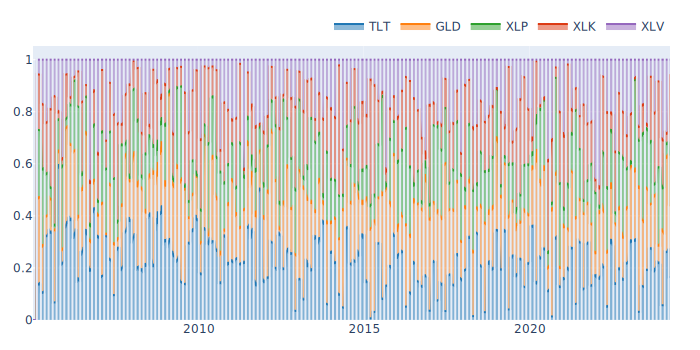

In [42]:
plot_allocation(srb_pf)

You can see how weights stabilize themselves with growing data.

In [43]:
# Run simulation, but now consider only the last 252 days of data
srb252_sharpe = np.full(price.shape[0], np.nan)

srb252_pf = vbt.Portfolio.from_order_func(
    price,
    order_func_nb,
    pre_sim_func_nb=pre_sim_func_nb,
    pre_sim_args=(30,),
    pre_segment_func_nb=pre_segment_func_nb,
    pre_segment_args=(find_weights_nb, 252, ann_factor, num_tests, srb252_sharpe),
    cash_sharing=True, 
    group_by=True
)

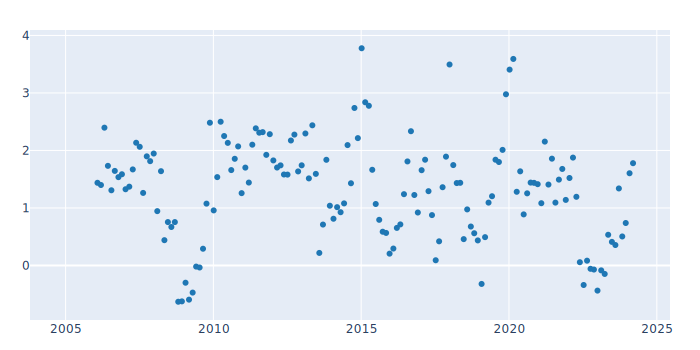

In [44]:
pd.Series(srb252_sharpe, index=price.index).vbt.scatterplot(trace_kwargs=dict(mode='markers')).show_svg()

In [45]:
print(srb252_pf.stats())

Start                                  2005-01-03 00:00:00
End                                    2024-03-28 00:00:00
Period                                  4842 days 00:00:00
Start Value                                          100.0
End Value                                       477.860095
Total Return [%]                                377.860095
Benchmark Return [%]                            537.127071
Max Gross Exposure [%]                               100.0
Total Fees Paid                                        0.0
Max Drawdown [%]                                   22.0239
Max Drawdown Duration                    502 days 00:00:00
Total Trades                                           388
Total Closed Trades                                    383
Total Open Trades                                        5
Open Trade PnL                                   35.226242
Win Rate [%]                                      73.10705
Best Trade [%]                                   30.8380

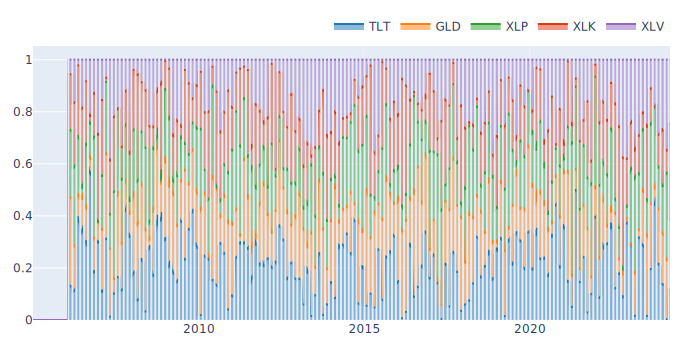

In [46]:
plot_allocation(srb252_pf)

A much more volatile weight distribution.

## PyPortfolioOpt + vectorbt

### One-time allocation

In [47]:
# Calculate expected returns and sample covariance amtrix
avg_returns = expected_returns.mean_historical_return(price)
cov_mat = risk_models.sample_cov(price)

# Get weights maximizing the Sharpe ratio
ef = EfficientFrontier(avg_returns, cov_mat)
weights = ef.max_sharpe()
clean_weights = ef.clean_weights()
pyopt_weights = np.array([clean_weights[symbol] for symbol in symbols])

print(pyopt_weights)

[0.2214  0.23854 0.18323 0.22078 0.13604]


In [48]:
pyopt_size = np.full_like(price, np.nan)
pyopt_size[0, :] = pyopt_weights  # allocate at first timestamp, do nothing afterwards

print(pyopt_size.shape)

(4842, 5)


In [49]:
# Run simulation with weights from PyPortfolioOpt
pyopt_pf = vbt.Portfolio.from_orders(
    close=price,
    size=pyopt_size,
    size_type='targetpercent',
    group_by=True,
    cash_sharing=True
)

print(len(pyopt_pf.orders))

5


Faster than stacking solution, but doesn't let you compare weights.

In [50]:
print(pyopt_pf.stats())

Start                         2005-01-03 00:00:00
End                           2024-03-28 00:00:00
Period                         4842 days 00:00:00
Start Value                                 100.0
End Value                              600.804709
Total Return [%]                       500.804709
Benchmark Return [%]                   537.127071
Max Gross Exposure [%]                  99.999834
Total Fees Paid                               0.0
Max Drawdown [%]                        21.160598
Max Drawdown Duration           493 days 00:00:00
Total Trades                                    5
Total Closed Trades                             0
Total Open Trades                               5
Open Trade PnL                         500.804709
Win Rate [%]                                  NaN
Best Trade [%]                                NaN
Worst Trade [%]                               NaN
Avg Winning Trade [%]                         NaN
Avg Losing Trade [%]                          NaN


### Search and rebalance monthly

You can't use third-party optimization packages within Numba (yet).

Here you have two choices:
1) Use `os.environ['NUMBA_DISABLE_JIT'] = '1'` before all imports to disable Numba completely
2) Disable Numba for the function, but also for every other function in the stack that calls it

We will demonstrate the second option.

In [51]:
def pyopt_find_weights(sc, price, num_tests):  # no @njit decorator = it's a pure Python function
    # Calculate expected returns and sample covariance matrix
    price = pd.DataFrame(price, columns=symbols)
    avg_returns = expected_returns.mean_historical_return(price)
    cov_mat = risk_models.sample_cov(price)

    # Get weights maximizing the Sharpe ratio
    ef = EfficientFrontier(avg_returns, cov_mat)
    weights = ef.max_sharpe()
    clean_weights = ef.clean_weights()
    weights = np.array([clean_weights[symbol] for symbol in symbols])
    best_sharpe_ratio = base_optimizer.portfolio_performance(weights, avg_returns, cov_mat)[2]
            
    return best_sharpe_ratio, weights

In [52]:
pyopt_srb_sharpe = np.full(price.shape[0], np.nan)

# Run simulation with a custom order function
pyopt_srb_pf = vbt.Portfolio.from_order_func(
    price,
    order_func_nb,
    pre_sim_func_nb=pre_sim_func_nb,
    pre_sim_args=(30,),
    pre_segment_func_nb=pre_segment_func_nb.py_func,  # run pre_segment_func_nb as pure Python function
    pre_segment_args=(pyopt_find_weights, -1, ann_factor, num_tests, pyopt_srb_sharpe),
    cash_sharing=True, 
    group_by=True,
    use_numba=False  # run simulate_nb as pure Python function
)

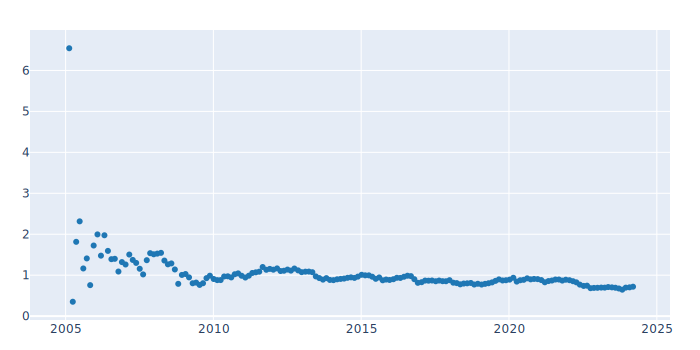

In [53]:
pd.Series(pyopt_srb_sharpe, index=price.index).vbt.scatterplot(trace_kwargs=dict(mode='markers')).show_svg()

In [54]:
print(pyopt_srb_pf.stats())

Start                                  2005-01-03 00:00:00
End                                    2024-03-28 00:00:00
Period                                  4842 days 00:00:00
Start Value                                          100.0
End Value                                       413.996571
Total Return [%]                                313.996571
Benchmark Return [%]                            537.127071
Max Gross Exposure [%]                               100.0
Total Fees Paid                                        0.0
Max Drawdown [%]                                 23.197328
Max Drawdown Duration                    566 days 00:00:00
Total Trades                                           320
Total Closed Trades                                    315
Total Open Trades                                        5
Open Trade PnL                                   93.158872
Win Rate [%]                                     92.380952
Best Trade [%]                                  105.1198

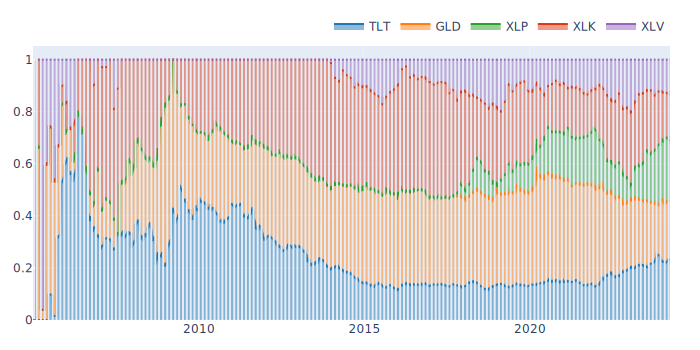

In [55]:
plot_allocation(pyopt_srb_pf)